# Spatially conditioned image generation

An adaptation of the notebook made by Katherine Crowson (https://github.com/crowsonkb), using explainability maps to condition the generation with sptial masks. 


In [ ]:
!nvidia-smi

In [3]:
!git clone https://github.com/apple/ml-no-token-left-behind.git
import os
os.chdir(f'ml-no-token-left-behind')

!pip install ftfy regex tqdm omegaconf pytorch-lightning
!pip install kornia
!pip install imageio-ffmpeg   
!pip install einops       
!pip install captum omegaconf==2.0.0

!mkdir pretrained_models
os.chdir('pretrained_models')

!curl -L -o vqgan_imagenet_f16_16384.yaml -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fconfigs%2Fmodel.yaml&dl=1' #ImageNet 16384
!curl -L -o vqgan_imagenet_f16_16384.ckpt -C - 'https://heibox.uni-heidelberg.de/d/a7530b09fed84f80a887/files/?p=%2Fckpts%2Flast.ckpt&dl=1' #ImageNet 16384
os.chdir('..')

mkdir: cannot create directory ‘pretrained_models’: File exists
** Resuming transfer from byte position 692
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
** Resuming transfer from byte position 980092370
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0


In [4]:
# @title Load libraries and variables

import os
import json
import torch
from PIL import Image
from omegaconf import OmegaConf
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from captum.attr import visualization
from torchvision import transforms
from argparse import Namespace
import torch
import torchvision.transforms as transforms
import sys
import numpy as np
from PIL import ImageFile, Image
ImageFile.LOAD_TRUNCATED_IMAGES = True
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import argparse
import math
from pathlib import Path
import sys
from IPython import display
from base64 import b64encode
from PIL import Image
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms import functional as TF
from tqdm.notebook import tqdm
import kornia.augmentation as K
import numpy as np
import imageio
from IPython.display import display

sys.path.insert(0, "./external/tamingtransformers")
sys.path.append("./external/TransformerMMExplainability")
import taming.modules 
import external.tamingtransformers.taming.models.cond_transformer as cond_transformer
import external.tamingtransformers.taming.models.vqgan as vqgan
import external.TransformerMMExplainability
import external.TransformerMMExplainability.CLIP.clip as clip

device = 'cuda:0'

from external.TransformerMMExplainability.CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))


def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()


def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]


def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.view([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.view([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)


class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward

    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)


replace_grad = ReplaceGrad.apply


class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)

    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min, ctx.max)) >= 0), None, None


clamp_with_grad = ClampWithGrad.apply


def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1.):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow

        self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7, padding_mode='border', same_on_batch=True),
            K.RandomPerspective(0.7,p=0.7, same_on_batch=True)
        )
        self.img_augs = nn.Sequential(
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), p=0.7),
        )
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size, self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size, self.cut_size))

    def forward(self, input, input_masks):
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        cutouts = []
        augmented_masks = []
        
        for _ in range(self.cutn):
          masks = []

          cutout = (self.av_pool(input) + self.max_pool(input))/2
          for mask_i in range(len(input_masks)):
              masks.append((self.av_pool(input_masks[mask_i]) + self.max_pool(input_masks[mask_i]))/2)

          sample = torch.cat([cutout] + masks, dim=0)
          beg_neutral_masks = len([cutout] + masks)
          aug_sample = self.augs(sample)
          cutouts.append(aug_sample[0])

          curr_augmented_masks = aug_sample[1:beg_neutral_masks]
          curr_augmented_masks = curr_augmented_masks[:, 0:1, ...]
          curr_augmented_masks = torch.round(curr_augmented_masks)

          augmented_masks.append(curr_augmented_masks)

          batch = torch.stack(cutouts, dim=0)
          batch = self.img_augs(batch)
          augmented_masks = torch.stack(augmented_masks, dim=0)
          if self.noise_fac:
              facs = batch.new_empty([self.cutn, 1, 1, 1]).uniform_(0, self.noise_fac)
              batch = batch + facs * torch.randn_like(batch)
          return batch, augmented_masks


def load_vqgan_model(config_path, checkpoint_path):
    config = OmegaConf.load(config_path)
    if config.model.target == 'taming.models.vqgan.VQModel':
        model = vqgan.VQModel(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.vqgan.GumbelVQ':
        model = vqgan.GumbelVQ(**config.model.params)
        model.eval().requires_grad_(False)
        model.init_from_ckpt(checkpoint_path)
    elif config.model.target == 'taming.models.cond_transformer.Net2NetTransformer':
        parent_model = cond_transformer.Net2NetTransformer(**config.model.params)
        parent_model.eval().requires_grad_(False)
        parent_model.init_from_ckpt(checkpoint_path)
        model = parent_model.first_stage_model
    else:
        raise ValueError(f'unknown model type: {config.model.target}')
    del model.loss
    return model


def resize_image(image, out_size):
    ratio = image.size[0] / image.size[1]
    area = min(image.size[0] * image.size[1], out_size[0] * out_size[1])
    size = round((area * ratio)**0.5), round((area / ratio)**0.5)
    return image.resize(size, Image.LANCZOS)


def spatial_explainability_loss(image, mask, model, text_tokenized, batch_size, t, temperature):
    text = text_tokenized.repeat(batch_size, 1)
    index = [i for i in range(batch_size)]
    clip_c = model.logit_scale.exp()
    model.zero_grad()

    with torch.enable_grad():
        logits_per_image, logits_per_text = model(image, text)
        logits_per_image = logits_per_image
        logits_per_image = logits_per_image / clip_c

        one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
        one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.to(image.device) * logits_per_image)
        # model.zero_grad()
        # one_hot.backward(retain_graph=True, create_graph=True)

        # image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
        # num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
        # R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(logits_per_image.device)
        # R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
        
        # for blk_idx, blk in enumerate(image_attn_blocks):
        #     if blk_idx <= 10:
        #         continue
            
        #     grad = blk.attn_grad
        #     cam = blk.attn_probs

        image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())
        num_tokens = image_attn_blocks[0].attn.attn_output_weights.shape[-1]
        R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn.attn_output_weights.dtype).to(logits_per_image.device)
        R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
        
        for blk_idx, blk in enumerate(image_attn_blocks):
            if blk_idx <= 10:
                continue

            grad = torch.autograd.grad(one_hot, [blk.attn.attn_output_weights], retain_graph=True, create_graph=True)[0]
            cam = blk.attn.attn_output_weights
            cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
            grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
            cam = grad * cam
            cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
            cam = cam.clamp(min=0).mean(dim=1)
            R = R + torch.bmm(cam, R)

        R[:, 0, 0] = 0
        image_relevance = R[:, 0, 1:]

        image_relevance = image_relevance.reshape(-1, 1, 7, 7)
        image_relevance = torch.nn.functional.interpolate(image_relevance, size=mask.shape[-1], mode='bicubic')
        image_relevance = image_relevance / torch.sum(image_relevance, dim=(-2, -1), keepdim=True)
        max = image_relevance.max(dim=-1, keepdim=True)[0]
        max = max.max(dim=-2, keepdim=True)[0]
        img_expl = image_relevance / max

        img_expl = (img_expl - t) * temperature
        binarized_expl = torch.sigmoid(img_expl)
        
        mask = mask.to(img_expl.device)
        intersection = (binarized_expl * mask).float().sum((-2, -1))
        union = (binarized_expl * (1 - mask)).float().sum((-2, -1))
        mask_size = (mask.shape[0] * mask.shape[1] * mask.shape[2] * mask.shape[3])
        dice_loss = (2 * intersection / (2 * intersection + union))

    model.zero_grad()
    return (-1) * dice_loss

class Prompt(nn.Module):
    def __init__(self, text, perceptor, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('tokenized_text', clip.tokenize(txt))
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
        self.t = 0.1  # threshold
        self.temperature = 20 # temp

        self.model = perceptor

    def forward(self, input, mask, dynamic_lambda):
        masked_input = input * mask.to(input.device)
        masked_input = torch.cat([input, masked_input], dim=0)

        expl_loss = spatial_explainability_loss(input, mask, self.model, self.tokenized_text, input.shape[0], self.t, self.temperature)
        expl_loss = expl_loss * dynamic_lambda

        input = self.model.encode_image(masked_input).float()
        # input = input.to(clip_device)
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        
        embed = perceptor.encode_text(self.tokenized_text).float()
        embed_normed = F.normalize(embed.unsqueeze(0), dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        
        loss = replace_grad(dists, torch.maximum(dists, self.stop)).mean() + expl_loss.mean()
        return self.weight.abs() * loss


## Settings for this run:
Specify in "texts" the objects you want to be generated in the image, seperated by '|'. The prefix "a photo of" will be added to each of them later.

For the spatial masks, yoy can either provide paths to existing mask images (black images, with white blobs describing the target object's location) in **paths to spatial masks** or specify bounding box indices (left, top, width, height) in **spatial conditioning by indices**. 
The masks will be generated/resized according to the specified height and width.

** **Due to memory limit we set cutn=16. Our experiments, as well as the original VQGAN+CLIP colab set cutn=32**

selected conditions:
a photo of a road


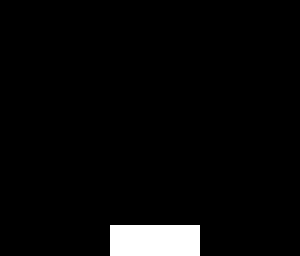


a photo of houses


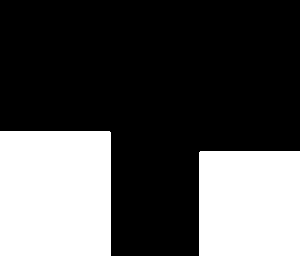

In [10]:
#@title Parameters
texts = "a road | houses" #@param {type:"string"}
paths_to_spatial_masks = "imgs/a_road_mask.png | imgs/houses_mask.png" #@param {type:"string"}
spatial_conditioning_by_indices = "0, 200, 300, 56 | 100, 50, 180, 70" #@param {type:"string"}
width =  300#@param {type:"number"}
height = 256#@param {type:"number"}
model = "vqgan_imagenet_f16_16384" 
init_image = ""
target_images = ""
seed = 42#@param {type:"number"}
max_iterations = 1000#@param {type:"number"}  
expl_loss_weight = 0.15 #@param {type:"number"}  
expl_weight_according_to_mask_ratio = True #@param {type:"boolean"}  
images_interval = 100#@param {type:"number"}
cutn = 16 #@param {type:"number"}

if seed == -1:
    seed = None

texts = ['a photo of ' + phrase.strip() for phrase in texts.split("|")]
if texts == ['']:
    texts = []

masks = []
existing_objects = {}
lambdas = torch.full((len(texts), 1), expl_loss_weight).to(device)

use_masks_from_file = True
mask_files = [phrase.strip() for phrase in paths_to_spatial_masks.split("|")]

if len(mask_files) != len(texts):
  use_masks_from_file = False

for mask_idx, mask_file in enumerate(mask_files):
  if not os.path.exists(mask_file):
    use_masks_from_file = False
    break
  
  mask = transforms.functional.to_tensor(Image.open(mask_file))[:3].unsqueeze(0)
  mask = torch.nn.functional.interpolate(mask, size=(height, width), mode='bilinear')
  mask = torch.round(mask)
  mask = mask.to(device)

  mask_ratio = mask.mean()

  if expl_weight_according_to_mask_ratio:
      lambdas[mask_idx] = lambdas[mask_idx] * (1 / mask_ratio.sqrt())

  masks.append(mask)

if not use_masks_from_file:
  masks = []
  mask_indices = [phrase.strip() for phrase in spatial_conditioning_by_indices.split("|")]
  for mask_idx, mask_bb_indices in enumerate(mask_indices):
    
    mask = torch.zeros((1, 3, height, width))
    left, top, mask_width, mask_height = [int(num.strip()) for num in mask_bb_indices.split(',')]
    if left < 0 or top < 0 or left+mask_width > width or top+mask_height > height:
      raise RuntimeError("The indices of the mask are out of bounds")

    mask[..., top:top+mask_height, left:left+mask_width] = 1.
    mask = mask.to(device)

    mask_ratio = mask.mean()
    if expl_weight_according_to_mask_ratio:
        lambdas[mask_idx] = lambdas[mask_idx] * (1 / mask_ratio.sqrt())

    masks.append(mask)

if len(masks) != len(texts):
    raise RuntimeError("The number of masks must match the number of texts")

print('selected conditions:')
for idx in range(len(texts)):
    print(texts[idx])
    display(Image.fromarray(masks[idx].cpu().numpy()[0].transpose(1, 2, 0).astype(np.uint8) * 255))
    print()

args = argparse.Namespace(
    prompts=texts,
    masks=masks,
    lambdas=lambdas,
    size=[width, height],
    clip_model='ViT-B/32',
    step_size=0.1,
    cutn=cutn,
    cut_pow=1.,
    image_intervals=images_interval,
    seed=seed,
)


Using device: cuda:0
Using seed: 42
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from pretrained_models/vqgan_imagenet_f16_16384.ckpt


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:333: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


0it [00:00, ?it/s]

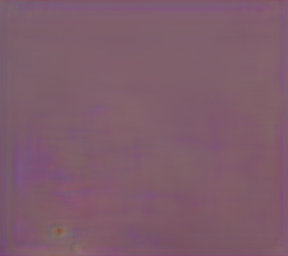

i: 0, loss: 1.74024, losses: 0.889463, 0.850779


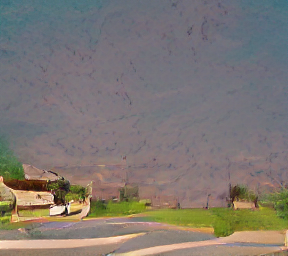

i: 100, loss: 1.47284, losses: 0.771615, 0.701225


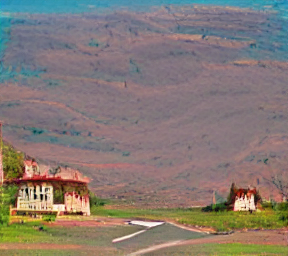

i: 200, loss: 1.42578, losses: 0.758046, 0.667736


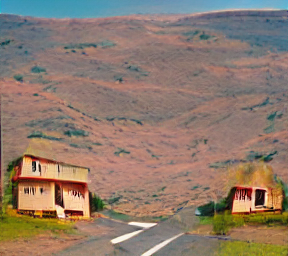

i: 300, loss: 1.6138, losses: 0.854009, 0.759789


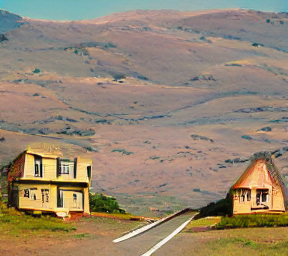

i: 400, loss: 1.30284, losses: 0.657398, 0.645439


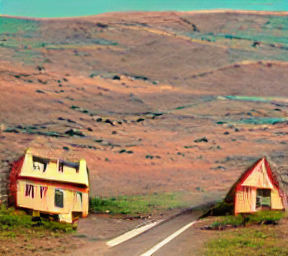

i: 500, loss: 1.18903, losses: 0.612804, 0.57623


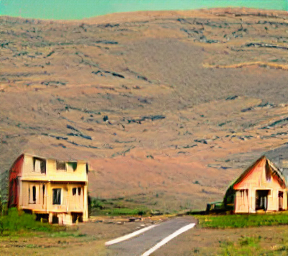

i: 600, loss: 1.21476, losses: 0.623863, 0.590894


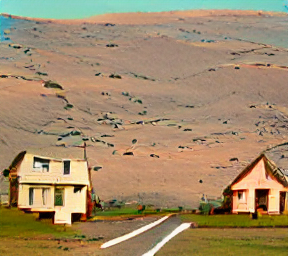

i: 700, loss: 1.24102, losses: 0.638454, 0.602564


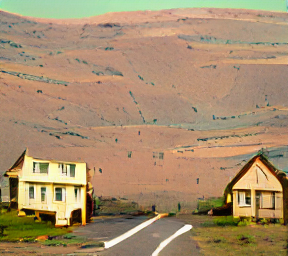

i: 800, loss: 1.34441, losses: 0.702923, 0.641485


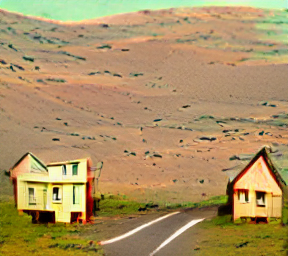

i: 900, loss: 1.15177, losses: 0.589976, 0.561798


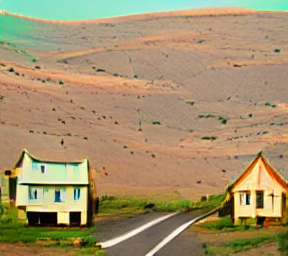

i: 1000, loss: 1.45956, losses: 0.778927, 0.680629


In [12]:
#@title Actually do the run...
from urllib.request import urlopen

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if args.seed is None:
    seed = torch.seed()
else:
    seed = args.seed
torch.manual_seed(seed)
print('Using seed:', seed)

model = load_vqgan_model(f'pretrained_models/vqgan_imagenet_f16_16384.yaml', f'pretrained_models/vqgan_imagenet_f16_16384.ckpt').to(device)
perceptor = clip.load(args.clip_model, jit=False)[0].to(device)
cut_size = perceptor.visual.input_resolution

f = 2**(model.decoder.num_resolutions - 1)
make_cutouts = MakeCutouts(cut_size, args.cutn, cut_pow=args.cut_pow)

toksX, toksY = args.size[0] // f, args.size[1] // f
sideX, sideY = toksX * f, toksY * f

for mask_id in range(len(masks)):
    masks[mask_id] = torch.nn.functional.interpolate(masks[mask_id], (sideY, sideX))
    masks[mask_id] = torch.round(masks[mask_id])
width, height = sideX, sideY

e_dim = model.quantize.e_dim
n_toks = model.quantize.n_e
z_min = model.quantize.embedding.weight.min(dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(dim=0).values[None, :, None, None]

one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX], device=device), n_toks).float()
z = one_hot @ model.quantize.embedding.weight
z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
z = torch.rand_like(z)*2
z_orig = z.clone()
z.requires_grad_(True)
opt = optim.Adam([z], lr=args.step_size)

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                  std=[0.26862954, 0.26130258, 0.27577711])

pMs = []

for prompt_idx, prompt in enumerate(args.prompts):
    txt, weight, stop = parse_prompt(prompt)
    pMs.append(Prompt(txt, perceptor, weight, stop).to(device))

def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

@torch.no_grad()
def checkin(i, losses):
    losses_str = ', '.join(f'{loss.item():g}' for loss in losses)
    tqdm.write(f'i: {i}, loss: {sum(losses).item():g}, losses: {losses_str}')
    out = synth(z)

def ascend_txt():
    global i
    out = synth(z)
    out_res = F.interpolate(out, size=256, mode='bilinear')
    iii, aug_masks = make_cutouts(out_res, masks.copy())
    iii = normalize(iii)
    
    result = []

    for prompt_idx, prompt in enumerate(pMs):
        result.append(prompt(iii, aug_masks[:, prompt_idx], lambdas[prompt_idx]))

    if i % args.image_intervals == 0:    
      img = np.array(out.mul(255).clamp(0, 255)[0].cpu().detach().numpy().astype(np.uint8))[:,:,:]
      img = Image.fromarray(np.transpose(img, (1, 2, 0)))
      display(img)

    return result

def train(i):
    opt.zero_grad()
    lossAll = ascend_txt()
    if i % args.image_intervals == 0:
        checkin(i, lossAll)
       
    loss = sum(lossAll)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))

i = 0
try:
    with tqdm() as pbar:
        while True:
            train(i)
            if i == max_iterations:
                break
            i += 1
            pbar.update()
except KeyboardInterrupt:
    pass